In [1]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import psycopg2
import os
import pandas as pd

# open file /run/secrets/postgres_pwd
with open(os.getenv("POSTGRES_PASSWORD_FILE"), 'r') as file:
    password = file.read().strip()

# Connect to your postgres DB
conn = psycopg2.connect(
    host="postgres",      # or IP address
    port=5432,             # default postgres port
    database=os.getenv("POSTGRES_DB"),
    user=os.getenv("POSTGRES_USER"),
    password="mysecretpassword"
)

In [2]:
# Create dataframe from SQL query
# This query calculates the average number of purchases per month for each user
# and the number of purchases in the last month.
sql = """
WITH months_count AS (
    SELECT COUNT(DISTINCT DATE_TRUNC('month', event_time)) AS total_months
    FROM customers
    WHERE event_type = 'purchase'
),
last_month AS (
    SELECT MAX(DATE_TRUNC('month', event_time)) AS max_month
    FROM customers
    WHERE event_type = 'purchase'
)
SELECT
    c.user_id,
    COUNT(*)::float / m.total_months AS avg_per_month,
    COUNT(*) FILTER (
        WHERE DATE_TRUNC('month', c.event_time) = l.max_month
    ) AS last_month_purchases
FROM customers c
JOIN months_count m ON true
JOIN last_month l ON true
WHERE c.event_type = 'purchase'
GROUP BY c.user_id, m.total_months, l.max_month
ORDER BY c.user_id;
"""
df = pd.read_sql_query(sql, conn)

/tmp/ipykernel_8041/1319183931.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


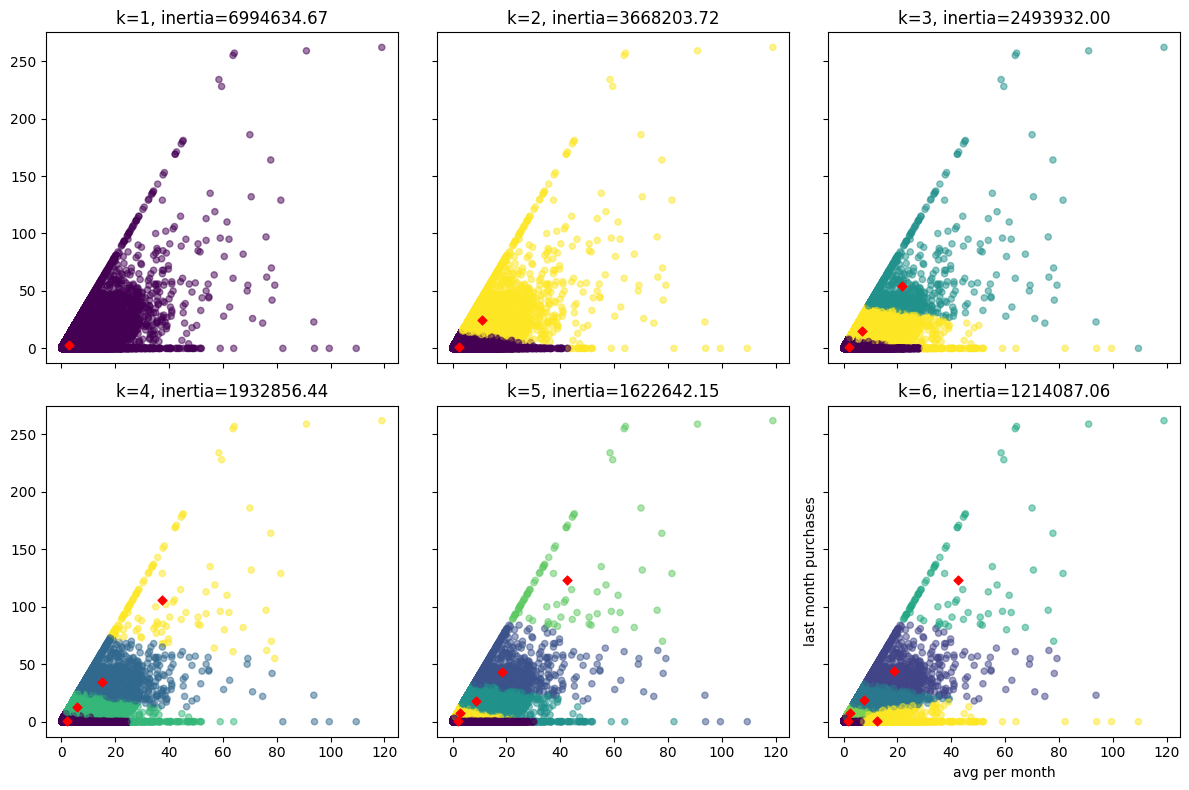

In [3]:
# kmeans clustering
X = df[['avg_per_month', 'last_month_purchases']].values
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
k=1
ssd=[] # sum of squared distances(inertia)
plt.ylabel('last month purchases')
plt.xlabel('avg per month')
for r in range (ax.shape[0]):
    for c in range(ax.shape[1]):
        m=KMeans(n_clusters=k, random_state=42)
        m.fit(X)
        ssd.append(m.inertia_)
        ax[r, c].scatter(X[:, 0], X[:, 1], s=20, alpha=0.5, c=m.labels_)
        ax[r, c].scatter(m.cluster_centers_[:, 0], m.cluster_centers_[:, 1], s=20, c='red', marker='D')
        ax[r, c].set_title(f'k={k}, inertia={m.inertia_:.2f}')
        k+=1
plt.tight_layout()
plt.show()  

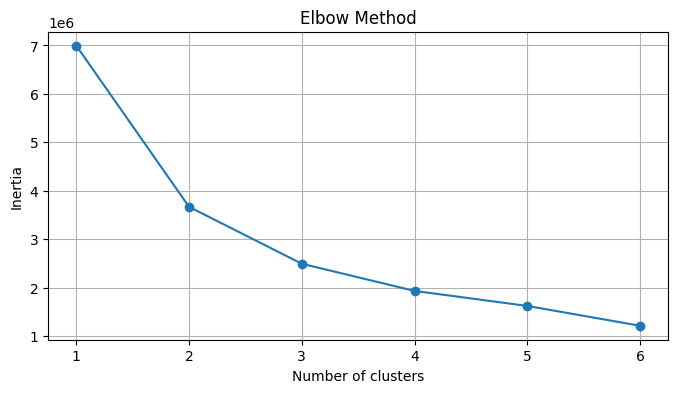

In [4]:
# plotting the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(ssd) + 1), ssd, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, len(ssd) + 1))
plt.grid()
plt.show()

# le6 is 10^6